In [441]:
import numpy as np
import matplotlib.pylab as plt
import skimage
from skimage.feature import register_translation as phase_cross_correlation
#from skimage.registration import phase_cross_correlation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [379]:
from skimage.transform import rotate
#(image, angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True, preserve_range=False)

In [442]:
# FFT shift interpolation
def fft_translate(A, dx, dy):
    a = np.fft.fft2(A)

    kx = np.fft.fftfreq(A.shape[0])
    ky = np.fft.fftfreq(A.shape[1])

    k_xy = np.meshgrid(kx, ky, indexing='ij')

    b2 = a*np.exp(-1j*np.pi*2*(dx*k_xy[0] + dy*k_xy[1]))

    B = np.abs( np.fft.ifft2(b2) )

    return B

def norm(*many_A):
    return ((A - np.mean(A))/A.std() for A in many_A)


def crop(I, xy_center, half_size):
    """Return the centered square at the position xy """

    j, i = np.around(xy_center).astype(np.int)
    i_slicing = np.s_[i - half_size:i + half_size + 1]
    j_slicing = np.s_[j - half_size:j + half_size + 1]

    return I[i_slicing, j_slicing]


def radial_std(s):
    s = np.vstack(s)
    ss = np.sqrt( np.sum((s - np.mean(s, axis=0))**2, axis=1) )
    return ss.mean()

def run_shifts(A, B, sigma, N=100, upsample_factor=10):
    shifts = []
    for k in range(N):
        shift, err, _ = phase_cross_correlation(B + sigma*np.random.randn(*A.shape),
                                                A,
                                                upsample_factor=upsample_factor)
        shifts.append(shift)
        #print(k, N, end='\r')

    s = np.vstack(shifts)
    # radial std
    ss = np.sqrt( np.sum((s - np.mean(s, axis=0))**2, axis=1) )
    
    return ss.mean()


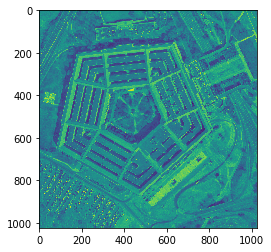

In [443]:
# ================
#  Generate data
# ================

# Pentagon aerial photo
# http://sipi.usc.edu/database/database.php?volume=aerials&image=37#top
image = skimage.data.camera()
image = skimage.io.imread('pentagon_1024.tiff')
image = skimage.exposure.rescale_intensity(image)
plt.imshow(image);

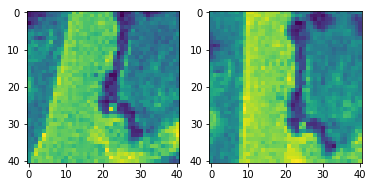

In [445]:
dx, dy = 5.5, 0.2
theta=  10.10
xy_center = 350, 500
half_size = 20

A = crop(image, xy_center, half_size)
B = crop(rotate(fft_translate(image, dx, dy), theta, center=xy_center, order=3),
         xy_center, half_size)
A, B = norm(A, B)


ax1 = plt.subplot(1, 2, 1)
ax1.imshow(A);
ax1 = plt.subplot(1, 2, 2)
ax1.imshow(B);

In [446]:
from scipy.signal.windows import blackman

u = blackman(A.shape[0])[:, np.newaxis]
v = blackman(A.shape[1])[np.newaxis, :]
window = np.matmul(u, v)

#plt.imshow(window); plt.title('blackman window');

In [447]:
# custom changed function:
from _phase_cross_correlation import phase_cross_correlation as cross_corr

In [422]:
def normed(A):
    return (A - A.mean())/A.std()

In [491]:
sigma = 1.005
Ap = A*window
Bp = normed( B + sigma*np.random.randn(*A.shape) )*window
shift, CC_coarse, CC = cross_corr(Ap, Bp,
           upsample_factor=100)
print(shift)
print(np.sum(np.abs(CC_coarse)))

[-4.59 -0.62]
20183.181989795306


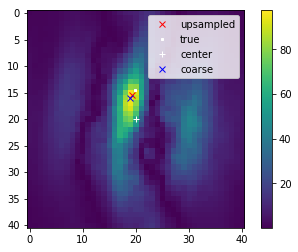

In [492]:
midpoints = np.fix(np.array(A.shape)/2)

plt.imshow(np.abs(CC_coarse)); plt.colorbar();
plt.plot(*(shift[::-1] + midpoints), 'x', color='red', label='upsampled')
plt.plot(*(-np.array([dy, dx]) + midpoints), 's', markersize=2, color='white', label='true')
plt.plot(*midpoints, '+', color='white', label='center')
plt.plot(*np.unravel_index(np.argmax(np.abs(CC_coarse)), CC_coarse.shape, order='F'), 'x', label='coarse', color='blue');
plt.legend();

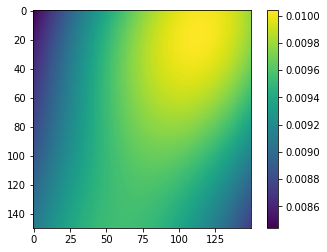

In [493]:
plt.imshow(np.abs(CC)); plt.colorbar();

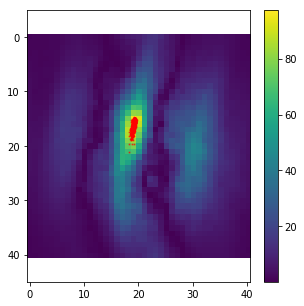

In [494]:
upsample_factor = 2
N = 710
shifts = []
for k in range(N):
    shift, err, _ = phase_cross_correlation(Ap,
                                            normed( B + sigma*np.random.randn(*A.shape) )*window,
                                            upsample_factor=10)
    shifts.append(shift)
    #print(k, N, end='\r')

shifts = np.vstack(shifts)

plt.figure(figsize=(5, 5));
plt.imshow(np.abs(CC_coarse)); plt.colorbar();

plt.plot(midpoints[1]+shifts[:, 1], midpoints[0]+shifts[:, 0], 'sr', alpha=0.5,
        markersize=1); plt.axis('equal');

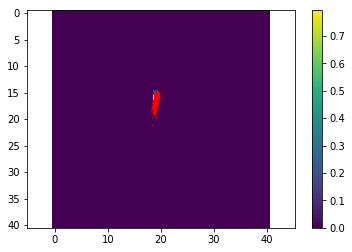

In [495]:
#sigma = 10
L = np.exp(np.abs(CC_coarse)/sigma**2)
L = L/np.sum(L)
plt.imshow(L); plt.colorbar();

plt.plot(midpoints[1]+shifts[:, 1], midpoints[0]+shifts[:, 0], 'sr', alpha=0.5,
        markersize=1); plt.axis('equal');

In [496]:
N = 234
upsample_factor = 100

sigma_span = np.logspace(-1, 1, 14)

s = dict()

dx, dy = 0.24680246, 1.35791357
xy_center = 550, 600

25912.83570117727


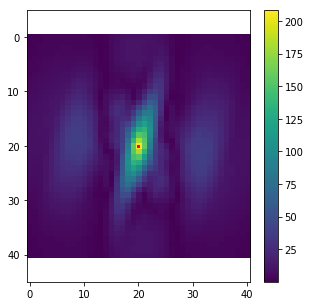

In [497]:
upsample_factor = 2
N = 710
shifts = []
for k in range(N):
    shift, err, _ = phase_cross_correlation(Ap,
                                            Ap,
                                            upsample_factor=10)
    shifts.append(shift)
    #print(k, N, end='\r')

shifts = np.vstack(shifts)

shift, CC_coarse, CC = cross_corr(Ap, Ap,
           upsample_factor=100)
print(np.sum(np.abs(CC_coarse)))

plt.figure(figsize=(5, 5));
plt.imshow(np.abs(CC_coarse)); plt.colorbar();

plt.plot(midpoints[1]+shifts[:, 1], midpoints[0]+shifts[:, 0], 'sr', alpha=0.5,
        markersize=1); plt.axis('equal');

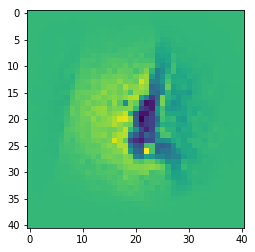

In [498]:
plt.imshow(Ap)

In [499]:
np.sum( Ap**2 )

208.3962803770583

In [293]:
half_size = 25

A = crop(image, xy_center, half_size)
B = crop(fft_translate(image, dx, dy), xy_center, half_size)
A, B = norm(A, B)

s[half_size] = [run_shifts(A, B, sig, N=N, upsample_factor=upsample_factor)
                for sig in sigma_span]

In [294]:
half_size = 50

A = crop(image, xy_center, half_size)
B = crop(fft_translate(image, dx, dy), xy_center, half_size)
A, B = norm(A, B)

s[half_size] = [run_shifts(A, B, sig, N=N, upsample_factor=upsample_factor)
                for sig in sigma_span]

In [296]:
half_size = 5

A = crop(image, xy_center, half_size)
B = crop(fft_translate(image, dx, dy), xy_center, half_size)
A, B = norm(A, B)

s[half_size] = [run_shifts(A, B, sig, N=N, upsample_factor=upsample_factor)
                for sig in sigma_span]

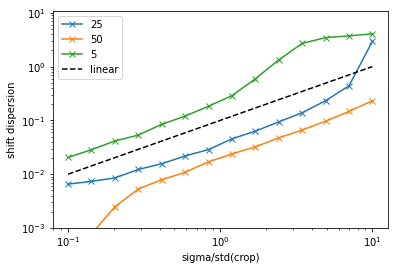

In [303]:
for half_size, std in s.items():
    plt.loglog(sigma_span, std, 'x-', label=f'{half_size}');
    
plt.plot([0.1, 10], [0.01, 1], '--k', label='linear')
plt.xlabel('sigma/std(crop)');
plt.ylabel('shift dispersion');
plt.ylim([0.1/upsample_factor, A.shape[0]]);
plt.legend();

In [326]:
N = 234
upsample_factor = 100
sigma = 1.0
size_span = np.arange(5, 80, 7)

s = []
for size in size_span:
    A = crop(image, xy_center, size)
    B = crop(fft_translate(image, dx, dy), xy_center, size)
    A, B = norm(A, B)

    s.append(run_shifts(A, B, sigma, N=N, upsample_factor=upsample_factor))

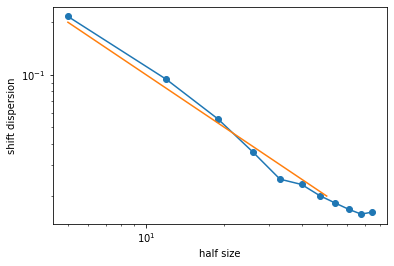

In [327]:
plt.loglog(size_span, s, 'o-')
plt.loglog([5, 50], [0.2, 0.2/10])
plt.xlabel('half size');
plt.ylabel('shift dispersion');

In [318]:
1/np.sqrt(10)

0.31622776601683794

### isotropic error 
1. en fonction de sigma  
    le ratio noise/signal est fonction de la position sur l'image (signal)
2. en fonction de window size
4. avec un bruit non Gausian random (fractal) 
    * avec la déformation
    
### non-isotropic error

i.e. textured image

* relation mathématique entre l'erreur et le bruit et la taille de l'image
dans le cadre du fit de peak
> Hagen, Nathan, Matthew Kupinski, et Eustace L. Dereniak. « Gaussian Profile Estimation in One Dimension ». Applied Optics 46, nᵒ 22 (1 août 2007): 5374. https://doi.org/10.1364/AO.46.005374.


eq. 16:
$$
var(x) \sim \frac{2}{\sqrt{\pi}} \left(\frac{\sigma}{A}\right)^2 \frac{w}{\delta_x}
$$
autrement dit
$$
std(x) \propto \frac{\sigma}{std(crop)} size^{-1/2}
$$

?? lien size--w 
et 1d vs 2d